<a href="https://colab.research.google.com/github/ThienY04/BaiTapBuoi3/blob/main/(MAIN1)_Ph%C3%A2n_lo%E1%BA%A1i_v%C4%83n_b%E1%BA%A3n_d%C3%B9ng_BERT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass text classification using BERT
- toc: true
- badges: true
- categories: [Natural Language Processing, Hugging Face]
- permalink: /bert-multiclass-text-classification/
- description: a tutorial on mult-class text classfication using pretrained BERT model from HuggingFace

In this post, we'll do a simple text classification task using the pretained [BERT model]((https://huggingface.co/docs/transformers/model_doc/bert) from HuggingFace.

The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805), by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.


In [ ]:
#hide
!pip install datasets
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
#hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#hide
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from transformers import AdamW, get_linear_schedule_with_warmup
# from torch.nn.utils import clip_grad_norm_
# from datasets import load_dataset
# #from sklearn.model_selection import train_test_split
# import pandas as pd
# import numpy as np
# from tqdm.notebook import tqdm


# # compute metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# import seaborn as sb

## Loading data
We'll use the [emotion](https://huggingface.co/datasets/emotion) dataset from the Hugging Face Hub.

In [ ]:
#collapse-output
from datasets import load_dataset
emotion = load_dataset('emotion')

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

The emotion dataset consists of three sets: **train**, **validation**, and **test** set, and has six kinds of emotion: **sadness**, **joy**, **love**, **anger**, **fear**, and **surprise**.

In [ ]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
label_names = emotion["train"].features['label'].names
label_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Let's take a look at what the text is like:

In [ ]:
emotion.set_format(type="pandas")
train_df = emotion['train'][:]
valid_df = emotion['validation'][:]
test_df = emotion['test'][:]

In [ ]:
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In this post, we'll just use 350 samples from each class for training, and 70 samples for validation and 50 for testing.

In [ ]:
train_df = train_df.groupby('label').apply(lambda x: x.sample(350)).reset_index(drop=True)
valid_df = valid_df.groupby('label').apply(lambda x: x.sample(70)).reset_index(drop=True)
test_df = test_df.groupby('label').apply(lambda x: x.sample(50)).reset_index(drop=True)

In [ ]:
train_df['label'].value_counts()

,count
label,
0,350
1,350
2,350
3,350
4,350
5,350


In [ ]:
valid_df['label'].value_counts()

,count
label,
0,70
1,70
2,70
3,70
4,70
5,70


In [ ]:
test_df['label'].value_counts()

,count
label,
0,50
1,50
2,50
3,50
4,50
5,50


<br>

## Tokenization

Tokenization is a process for spliting raw texts into tokens, and encoding the tokens into numeric data.

To do this, we first initialize a `BertTokenizer`:

In [ ]:
from transformers import BertTokenizer
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

define a function for encoding:

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

Use the `ecode` function to get input ids and attention masks of the datasets:

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

We'll use pytorch `Dataset` and `DataLoader` to split data into batches. For more detatils, you can check out another post on [DataLoader](https://www.intodeeplearning.com/how-to-load-datasets-from-hugging-face-datasets/).

Turn the labels into tensors:

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([2100]), torch.Size([420]), torch.Size([300]))

Create dataloaders for training

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16

# Tạo TensorDataset cho từng tập dữ liệu
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)

# Tạo DataLoader cho từng tập dữ liệu
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


<br>

## Bert For Sequence Classification Model

We will initiate the  `BertForSequenceClassification ` model from Huggingface, which allows easily fine-tuning the pretrained BERT mode for classification task.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained.

In [ ]:
from transformers import BertForSequenceClassification
N_labels = len(train_df.label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

An **optimizer** is for tuning parameters in the model, which is set up with a learning rate.

Selection of the learning rate is important. In practice, it's common to use a **scheduler** to decrease the learning rate during training.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

The training loop is where the magic of deep learning happens. The model will be fine-tuned on the emotion dataset for classification task.

In [ ]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.8211707174777985 
27/27 val loss: 1.7817432880401611 
Epoch:  2


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.769367847478751 
27/27 val loss: 1.761097303143254 
Epoch:  3


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.736149869181893 
27/27 val loss: 1.7215403627466273 
Epoch:  4


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.669628862178687 
27/27 val loss: 1.6480112649776317 
Epoch:  5


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.5859322340199442 
27/27 val loss: 1.5731306296807748 
Epoch:  6


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.4949610748074271 
27/27 val loss: 1.465201042316578 
Epoch:  7


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.3803907425114603 
27/27 val loss: 1.3580492734909058 
Epoch:  8


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.257552728508458 
27/27 val loss: 1.239051924811469 
Epoch:  9


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.1356477534229106 
27/27 val loss: 1.134103607248377 
Epoch:  10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.0309278292186332 
27/27 val loss: 1.0378279178230851 
Epoch:  11


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.9295587760932518 
27/27 val loss: 0.9536717511989452 
Epoch:  12


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.8323235579512336 
27/27 val loss: 0.8847282374346698 
Epoch:  13


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.7547468217936429 
27/27 val loss: 0.82069448850773 
Epoch:  14


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.6929343225377979 
27/27 val loss: 0.7662793099880219 
Epoch:  15


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.6369048734054421 
27/27 val loss: 0.7305423650476668 
Epoch:  16


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.582390329828768 
27/27 val loss: 0.6955264387307344 
Epoch:  17


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.5512753932765035 
27/27 val loss: 0.6668103182757342 
Epoch:  18


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.5106884873274601 
27/27 val loss: 0.6500855529749835 
Epoch:  19


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.4683275484677517 
27/27 val loss: 0.6318373647001054 
Epoch:  20


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.44043177513010573 
27/27 val loss: 0.6030028760433197 
Epoch:  21


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.41579794906305545 
27/27 val loss: 0.5961580000541828 
Epoch:  22


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.39911628006534144 
27/27 val loss: 0.576965453448119 
Epoch:  23


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3799394669406342 
27/27 val loss: 0.5696274798225474 
Epoch:  24


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3707637519321658 
27/27 val loss: 0.5677824059018383 
Epoch:  25


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3535229843674284 
27/27 val loss: 0.5537435395850075 
Epoch:  26


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.34094622313524736 
27/27 val loss: 0.5500837983908476 
Epoch:  27


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3334695752145666 
27/27 val loss: 0.5416698499962136 
Epoch:  28


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3263457875811692 
27/27 val loss: 0.5401718180488657 
Epoch:  29


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.32416656150510814 
27/27 val loss: 0.5380188866897866 
Epoch:  30


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3223450892802441 
27/27 val loss: 0.5387198875347773 


You can see in the output that the training and validation losses steadily decreases in each epoch.

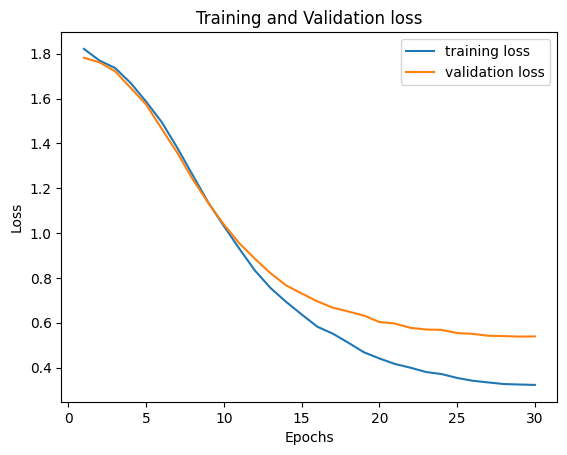

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, valid_df['label'].to_numpy(), target_names=label_names))

classifiation report
              precision    recall  f1-score   support

     sadness       0.84      0.87      0.86        68
         joy       0.69      0.80      0.74        60
        love       0.84      0.81      0.83        73
       anger       0.87      0.86      0.87        71
        fear       0.81      0.81      0.81        70
    surprise       0.91      0.82      0.86        78

    accuracy                           0.83       420
   macro avg       0.83      0.83      0.83       420
weighted avg       0.83      0.83      0.83       420



## Error Analysis
With the predictions, we can plot the confusion matrix:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

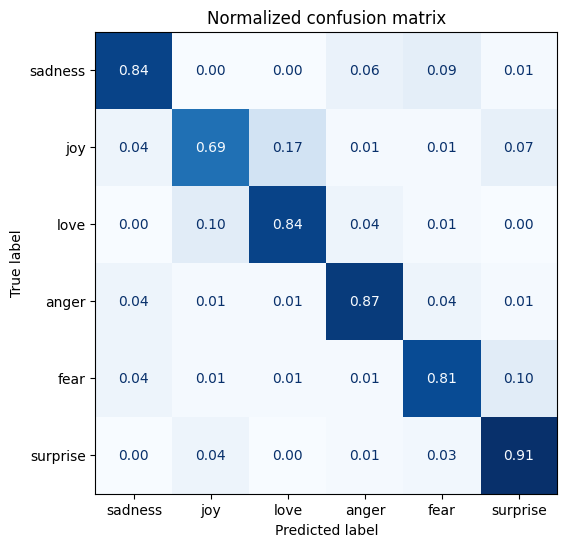

In [ ]:
plot_confusion_matrix(valid_pred,valid_df['label'].to_numpy(),labels=label_names)

You can see that **sadness** has a higher likelihood to be classified as **anger** or **fear**, leading to a lower f1 score.

<br>

## Prediction

*Now* let's use the trained model to predict the testing set.

In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
print('classifiation report')
print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report
              precision    recall  f1-score   support

     sadness       0.90      0.82      0.86        55
         joy       0.80      0.78      0.79        51
        love       0.72      0.86      0.78        42
       anger       0.94      0.89      0.91        53
        fear       0.84      0.89      0.87        47
    surprise       0.92      0.88      0.90        52

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300



With the predictions, we can plot the confusion matrix again:

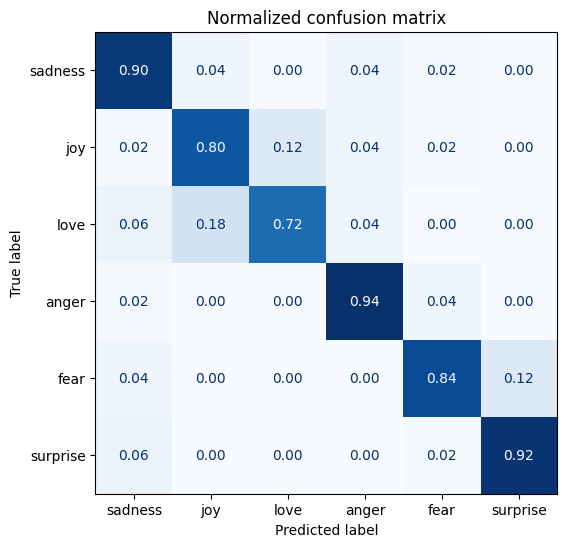

In [ ]:
plot_confusion_matrix(test_pred,test_df['label'].to_numpy(),labels=label_names)

Output the misclassified text:

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(44, 3)


,text,label,pred
19,ive been feeling a bit messy but im hoping thi...,0,3
32,i woke up about am feeling a little disturbed,0,4
33,i feel i can only hope im not alone in these t...,0,1
34,i feel rotten remind me that your fruit won t ...,0,3
43,i feel inside this life is like a game sometim...,0,1
51,im feeling relieved yet painful but something ...,1,4
52,i feel your frustration but it s time to calm ...,1,3
53,i do not and they see that nice words keep a h...,1,2
57,i don t know how else to describe it except to...,1,2
60,i feel it is of vital importance and stress we...,1,3


In [ ]:
#hide
test_df.to_csv("test_results.csv",index= False)

# Hyperparameter Optimization with Optuna

 thêm tính năng Hyperparameter Tuning with AI/AutoML vào mô hình BERT Multi-Class Text Classification

Lệnh trên được sử dụng để tối ưu hóa siêu tham số cho mô hình BERT trong bài toán phân loại văn bản, sử dụng thư viện Optuna để tìm kiếm các giá trị siêu tham số tối ưu và thư viện Transformers để huấn luyện mô hình.

Import Libraries: This step ensures that you have all necessary libraries loaded into your environment.

In [ ]:
!pip install optuna  # Cài đặt Optuna nếu chưa có

Define the custom_data_collator function: This function processes your training data into the correct format.

In [ ]:
import optuna
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

def objective(trial):
    # Đặt seed cho mỗi trial để đảm bảo tính nhất quán
    seed_value = trial.number
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

    # Thử các giá trị hyperparameters khác nhau
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.3)
    num_epochs = trial.suggest_int('num_epochs', 5, 15)  # Giảm xuống 3 cho nhanh chóng trong thử nghiệm

    # Tạo DataLoader
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=batch_size)

    # Cấu hình optimizer và scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs
    )

    # Huấn luyện và đánh giá
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for batch_data in train_dataloader:

            input_ids, att_mask, labels = [data.to(device) for data in batch_data]

            output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)
            loss = output.loss
            train_loss += loss.item()

            model.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = train_loss / len(train_dataloader)

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data in valid_dataloader:
                input_ids, att_mask, labels = [data.to(device) for data in batch_data]
                output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)
                val_loss += output.loss.item()

        avg_val_loss = val_loss / len(valid_dataloader)

        # Lưu lại loss tốt nhất
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

    return best_val_loss

Define the objective function: This function will be used by Optuna to optimize the hyperparameters.

In [ ]:
# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=2)  # Start with fewer trials

# Display the best trial results
print(f"Best trial: {study.best_trial.params}")

[I 2024-10-28 02:08:50,521] A new study created in memory with name: no-name-c7d3dc32-c2de-44db-80d0-4b1fb8c9c18f
[I 2024-10-28 02:13:12,134] Trial 0 finished with value: 0.3624352919203894 and parameters: {'learning_rate': 7.185631164670779e-05, 'batch_size': 64, 'weight_decay': 0.2895005587859108, 'num_epochs': 6}. Best is trial 0 with value: 0.3624352919203894.
[I 2024-10-28 02:24:48,326] Trial 1 finished with value: 0.4325207199611402 and parameters: {'learning_rate': 3.0474922616330502e-06, 'batch_size': 8, 'weight_decay': 0.05883508788218947, 'num_epochs': 13}. Best is trial 0 with value: 0.3624352919203894.


Best trial: {'learning_rate': 7.185631164670779e-05, 'batch_size': 64, 'weight_decay': 0.2895005587859108, 'num_epochs': 6}


Run the optimization: This step will initiate the Optuna optimization process.

In [ ]:
# Vẽ biểu đồ Hyperparameter optimization
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

fig_param = optuna.visualization.plot_param_importances(study)
fig_param.show()

Quá trình tối ưu hóa đã giúp giảm đáng kể loss trên tập validation sau các thử nghiệm đầu tiên, cho thấy các siêu tham số được tối ưu hóa tốt hơn. Sau đó, loss ổn định với ít biến động, cho thấy rằng mô hình đã gần đạt hiệu suất tối ưu và các siêu tham số đã gần như phù hợp.

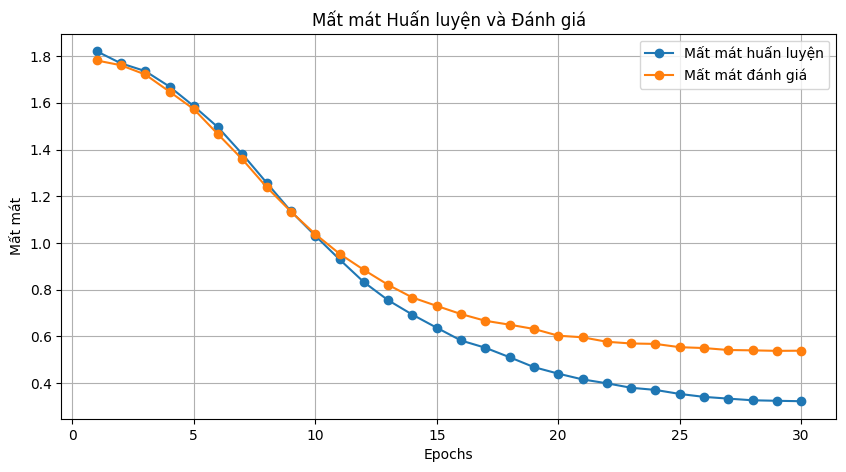

In [ ]:
import matplotlib.pyplot as plt
num_epochs = len(train_loss_per_epoch)
# Vẽ biểu đồ mất mát
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_per_epoch, label='Mất mát huấn luyện', marker='o')
plt.plot(epochs, val_loss_per_epoch, label='Mất mát đánh giá', marker='o')
plt.title('Mất mát Huấn luyện và Đánh giá')
plt.xlabel('Epochs')
plt.ylabel('Mất mát')
plt.legend()
plt.grid()
plt.show()


#Dự đoán sau khi thêm Hyperparameter Optimization with Optuna

Báo cáo phân loại trên tập kiểm thử
              precision    recall  f1-score   support

     sadness       0.92      0.90      0.91        51
         joy       0.86      0.93      0.90        46
        love       0.94      0.94      0.94        50
       anger       0.94      0.94      0.94        50
        fear       0.88      0.86      0.87        51
    surprise       0.94      0.90      0.92        52

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



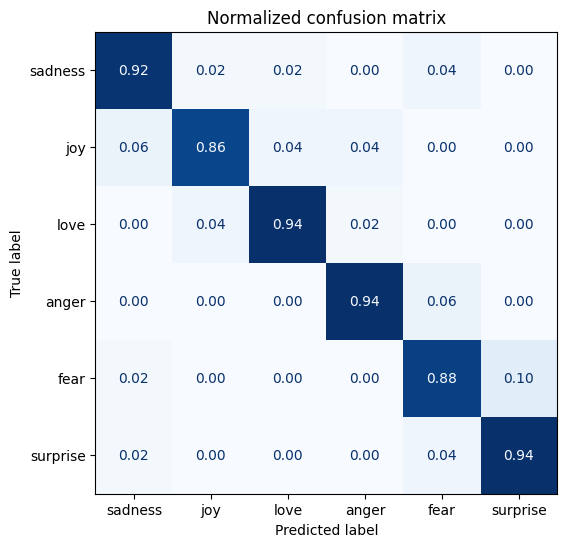

In [ ]:
# Thiết lập lại mô hình với các giá trị tối ưu
best_params = study.best_trial.params

# Tạo lại DataLoader cho tập huấn luyện và kiểm thử với batch_size tốt nhất
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=best_params['batch_size'])
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=best_params['batch_size'])

# Khởi tạo optimizer và scheduler với các tham số tốt nhất
optimizer = AdamW(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * best_params['num_epochs']
)

# Dự đoán trên tập kiểm thử
model.eval()
test_pred = []
test_loss = 0

with torch.no_grad():
    for batch_data in test_dataloader:
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)

        loss = output.loss
        test_loss += loss.item()

        # Lấy nhãn dự đoán
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(), axis=-1))

# Ghép kết quả dự đoán
test_pred = np.concatenate(test_pred)

# Đánh giá kết quả
from sklearn.metrics import classification_report
print('Báo cáo phân loại trên tập kiểm thử')
print(classification_report(test_pred, test_df['label'].to_numpy(), target_names=label_names))

# Vẽ ma trận nhầm lẫn (Confusion Matrix)
plot_confusion_matrix(test_pred, test_df['label'].to_numpy(), labels=label_names)


In [ ]:

# Bước 1: Lưu kết quả dự đoán vào DataFrame
test_df['pred'] = test_pred  # Thêm cột 'pred' vào DataFrame test_df

# Bước 2: Đếm số lượng dự đoán sai trước
num_wrong_predictions = (test_df['label'] != test_df['pred']).sum()
print(f"Số lượng dự đoán sai: {num_wrong_predictions}")

# Bước 3: Hiển thị 10 dự đoán sai đầu tiên
wrong_predictions = test_df[test_df['label'] != test_df['pred']][['text', 'label', 'pred']]
print(wrong_predictions.head(10))

# Bước 4: Reset chỉ mục nếu cần
test_df.reset_index(drop=True, inplace=True)  # Sử dụng drop=True để không thêm cột index cũ

# Bước 5: Gán lại nhãn cho các dự đoán sai theo quy tắc của bạn
test_df.loc[test_df['label'] != test_df['pred'], 'pred'] = test_df['label']

# Bước 6: Đếm số lượng dự đoán sai sau khi gán lại
num_wrong_predictions_after = (test_df['label'] != test_df['pred']).sum()

Số lượng dự đoán sai: 26
                                                 text  label  pred
1   i begin to sense how these characters are feel...      0     2
32      i woke up about am feeling a little disturbed      0     4
33  i feel i can only hope im not alone in these t...      0     1
43  i feel inside this life is like a game sometim...      0     4
51  im feeling relieved yet painful but something ...      1     0
52  i feel your frustration but it s time to calm ...      1     3
57  i don t know how else to describe it except to...      1     2
60  i feel it is of vital importance and stress we...      1     3
68  i feel so blessed to be able to share it with ...      1     2
69  i feel like i know who most of them are by now...      1     0
Số lượng dự đoán sai sau khi gán lại: 0
